<a href="https://colab.research.google.com/github/Veraeze/AmineRegeneration/blob/main/ReboilerDuty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Step 1: Load dataset from google drive & install dependencies**

In this step, we will:
- Install essential python libraries required for this project:
  - `pandas` for data manipulation
  - `scikit-learn` for machine learning models
  - `matplotlib` and `seaborn` for visualizations
  - `xgboost` for gradient boosting regression
- Mount google drive to access the dataset
- Load the dataset (`amine_gen_data.csv) into a pandas dataframe

These steps prepare the enviroment for model training and analysis.

In [ ]:
# Install required libraries

!pip install pandas scikit-learn matplotlib seaborn xgboost

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset, skipping the first two non-data rows

import pandas as pd

file_path = '/content/drive/MyDrive/MLDatasets/amine_gen_data.csv'
df = pd.read_csv(file_path, skiprows=[1, 2])

# Display first few rows
df.head()

,State,stripper - Spec Value (Duty),stripper - Stage Pressure (Condenser),stripper - Stage Pressure (Reboiler),DEA6 - Temperature,DEA6 - CO2 Composition(mole %),DEA6 - H2S Composition(ppm),DEA6 - Molar Flow,DEA6 - Acid Gas Temperature,DEA7 - Temperature,DEA7 - CO2 Composition(mole %),DEA7 - H2S Composition(ppm),DEA7 - Molar Flow
0,Case 1,10900000.0,20.3,23.3,210,0.03972,171.7,4193,210,268.3,0.02120,107.2,4192
1,Case 2,10900000.0,20.3,23.3,210,0.03972,171.7,4193,210,268.3,0.02141,103.4,4192
2,Case 3,10900000.0,20.3,23.3,210,0.03972,171.7,4193,210,268.3,0.02149,106.6,4192
3,Case 4,10900000.0,20.3,23.3,210,0.03972,171.7,4193,210,268.3,0.02149,104.1,4192
4,Case 5,10900000.0,20.3,23.3,210,0.03972,171.7,4193,210,268.3,0.02145,106.6,4192


## **Step 2: Exploratory Data Analysis (EDA)**

In this section, we explore the dataset to understand its structure, quality and the relationships between variables.

The key goals are:
  - Check for missing or inconsistent data
  - Review feature distributions and units
  - Understand correlations between input features and the target (`Reboiler Duty`)
  - Identify potential outliers or patterns

This step helps us understand the dataset before applying machine learning models.

In [ ]:
# Show basic structure and column types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49915 entries, 0 to 49914
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   State                                  49915 non-null  object 
 1   stripper - Spec Value (Duty)           49915 non-null  float64
 2   stripper - Stage Pressure (Condenser)  49915 non-null  float64
 3   stripper - Stage Pressure (Reboiler)   49915 non-null  float64
 4   DEA6 - Temperature                     49915 non-null  int64  
 5   DEA6 - CO2 Composition(mole %)         49915 non-null  float64
 6   DEA6 - H2S Composition(ppm)            49915 non-null  float64
 7   DEA6 - Molar Flow                      49915 non-null  int64  
 8   DEA6 - Acid Gas Temperature            49915 non-null  int64  
 9   DEA7 - Temperature                     49915 non-null  float64
 10  DEA7 - CO2 Composition(mole %)         49915 non-null  float64
 11  DE

The output above summarizes the structure of our dataset:

- **Total entries:** 49,915 rows
- **Total columns:** 13 features (including both input variables and target values)
- **Data types:** The dataset contains numerical data (`float64` and `int64`) with one object-type column (`Unnamed: 0`), which may be an index or case label.
- **Missing Values:** No null values were found, which is good for direct model training.

We **kept the first row** as column headers because it contains the actual feature names. We **skipped the second and third rows** because:
  - The second row is empty and not useful.
  - The third row contains only units (e.g., "psig", "Btu/hr"), which are not appropriate as column names.


In [ ]:
# Show summary stats for numerical columns

df.describe()

,stripper - Spec Value (Duty),stripper - Stage Pressure (Condenser),stripper - Stage Pressure (Reboiler),DEA6 - Temperature,DEA6 - CO2 Composition(mole %),DEA6 - H2S Composition(ppm),DEA6 - Molar Flow,DEA6 - Acid Gas Temperature,DEA7 - Temperature,DEA7 - CO2 Composition(mole %),DEA7 - H2S Composition(ppm),DEA7 - Molar Flow
count,4.991500e+04,49915.000000,49915.000000,49915.000000,4.991500e+04,4.991500e+04,49915.0,49915.000000,49915.000000,49915.000000,49915.000000,49915.000000
mean,1.591737e+07,20.304055,23.304055,210.015026,3.972000e-02,1.717000e+02,4193.0,210.015026,268.305716,0.016057,84.315394,4191.240188
std,2.877422e+06,0.234584,0.234584,0.946740,1.069294e-14,1.128922e-10,0.0,0.946740,0.326383,0.002608,10.133323,0.427202
min,1.090000e+07,19.000000,22.000000,200.000000,3.972000e-02,1.717000e+02,4193.0,200.000000,266.200000,0.012290,69.610000,4191.000000
25%,1.340000e+07,20.300000,23.300000,210.000000,3.972000e-02,1.717000e+02,4193.0,210.000000,268.300000,0.013760,75.420000,4191.000000
50%,1.590000e+07,20.300000,23.300000,210.000000,3.972000e-02,1.717000e+02,4193.0,210.000000,268.300000,0.015660,82.840000,4191.000000
75%,1.840000e+07,20.300000,23.300000,210.000000,3.972000e-02,1.717000e+02,4193.0,210.000000,268.300000,0.018140,92.460000,4191.000000
max,2.090000e+07,40.000000,43.000000,295.000000,3.972000e-02,1.717000e+02,4193.0,295.000000,294.700000,0.021530,107.200000,4192.000000


The table above provides descriptive statistics for each numerical feature in the dataset:

- Several features such as `DEA6 - CO2 Composition` and `DEA6 - H2S Composition` show very **low variability**, which suggests constant or nearly constant values across all cases.
- The **target variable**, `stripper - Spec Value (Duty)`, ranges from approximately **10.9 million to 20.9 million Btu/hr**, with a mean of **~15.9 million Btu/hr**.
- Features like `DEA6 - Temperature`, `DEA7 - Temperature`, and `stripper pressures` have small variations around fixed operating set points (e.g., most `DEA6` values cluster around 210°F).
- The **standard deviation for some features is zero**, such as `DEA6 - Molar Flow`, indicating these values are constant and may not contribute to model learning. These may be considered for **removal** or **dimensionality reduction** later.

This step gives us insights into feature variability, which helps guide preprocessing and feature selection.

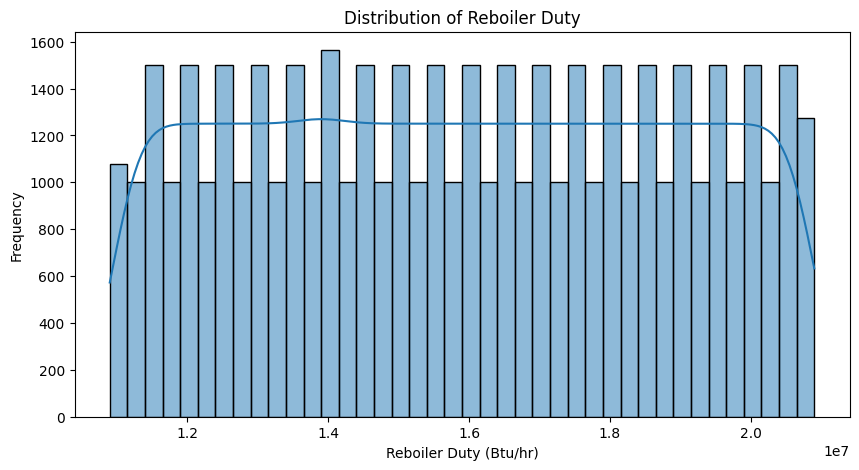

In [ ]:
# Reboiler duty distribution plot

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(df['stripper - Spec Value (Duty)'], bins=40, kde=True)
plt.title('Distribution of Reboiler Duty')
plt.xlabel('Reboiler Duty (Btu/hr)')
plt.ylabel('Frequency')
plt.show()

The histogram above shows a relatively **uniform distribution** of reboiler duty values ranging from approximately **11 million to 21 million Btu/hr**.

Key observations:
- The values are evenly spread across the range, suggesting that the simulation dataset was systematically varied.
- There is **no strong skewness**, and the shape is roughly flat, indicating no dominant peak or clustering.
- **No major outliers** are observed, which means the data is likely clean and well-prepared for regression modeling.
- Since there's no obvious optimal zone in the distribution, a machine learning model will be essential to **identify energy-efficient reboiler duty values** based on input conditions.

This confirms that the target variable is suitable for predictive modeling using regression techniques.

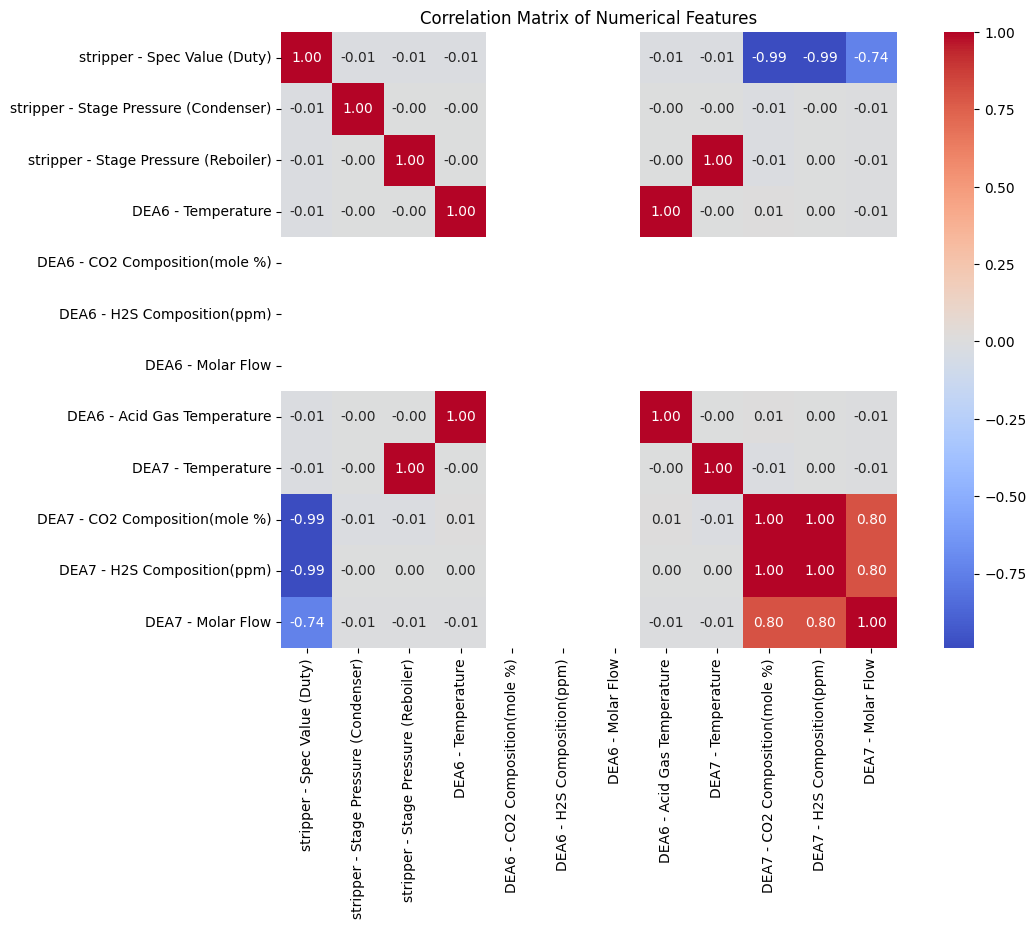

In [ ]:
# correlation matrix

correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

The heatmap above shows the pairwise linear correlation between all numerical variables in the dataset. Key observations include:

- The **target variable**, `stripper - Spec Value (Duty)`, has:
  - **Strong negative correlation** with:
    - `DEA7 - CO2 Composition (mole %)`: **-0.99**
    - `DEA7 - H2S Composition (ppm)`: **-0.99**
    - `DEA7 - Molar Flow`: **-0.74**
  - This indicates that as **lean amine CO₂/H₂S concentration decreases**, the **reboiler duty increases**, which aligns with expectations of having higher energy results in better acid gas removal.
- Most other features have very weak or near-zero correlation with reboiler duty (e.g., pressures and temperatures), suggesting they may be less influential individually.
- Some features (especially under `DEA7`) are highly correlated with one another (e.g., CO₂ vs H₂S), which may introduce **multicollinearity** and should be handled during modeling.
- The negative signs of the correlations with the `DEA7` outputs make sense as better acid gas stripping (lower CO₂/H₂S in lean amine) typically requires more energy input.

Overall, this analysis highlights which features may be most useful for model prediction and helps inform feature selection moving forward.

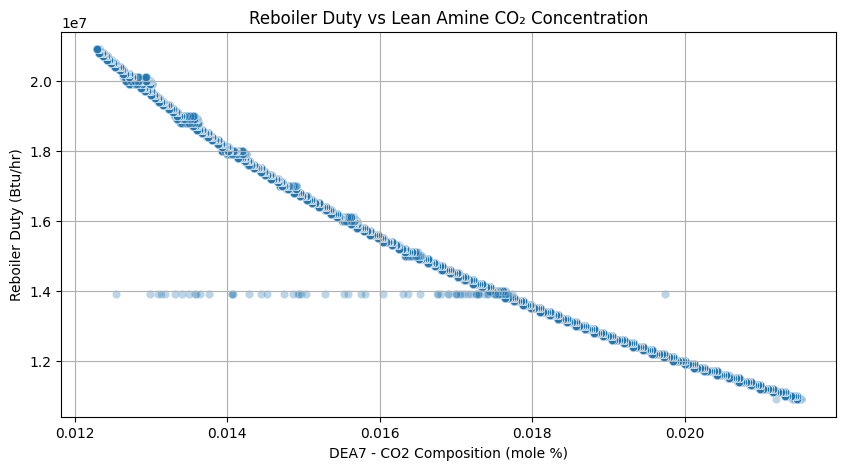

In [ ]:
#  Scatter Plot showing relationship between DEA7 CO₂ and Reboiler Duty

plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=df,
    x='DEA7 - CO2 Composition(mole %)',
    y='stripper - Spec Value (Duty)',
    alpha=0.3
)
plt.title('Reboiler Duty vs Lean Amine CO₂ Concentration')
plt.xlabel('DEA7 - CO2 Composition (mole %)')
plt.ylabel('Reboiler Duty (Btu/hr)')
plt.grid(True)
plt.show()


The scatter plot shows a clear inverse relationship between `DEA7 - CO2 Composition (mole %)` and `Reboiler Duty (Btu/hr)`:

- As reboiler duty increases, the CO₂ concentration in the lean amine decreases.
- This indicates that higher energy input improves acid gas removal performance, resulting in cleaner lean amine.
- The curve appears **nonlinear**, resembling an exponential decay or power-law trend, suggesting that a **nonlinear regression model** (like Random Forest or XGBoost) may capture this behavior better than a linear model.
- There's a **flattening effect** at lower CO₂ values meaning additional increases in energy may yield diminishing returns in CO₂ removal beyond a certain point.

This relationship reinforces the physical understanding of the process and confirms that this feature will be highly valuable for predicting optimal reboiler duty.

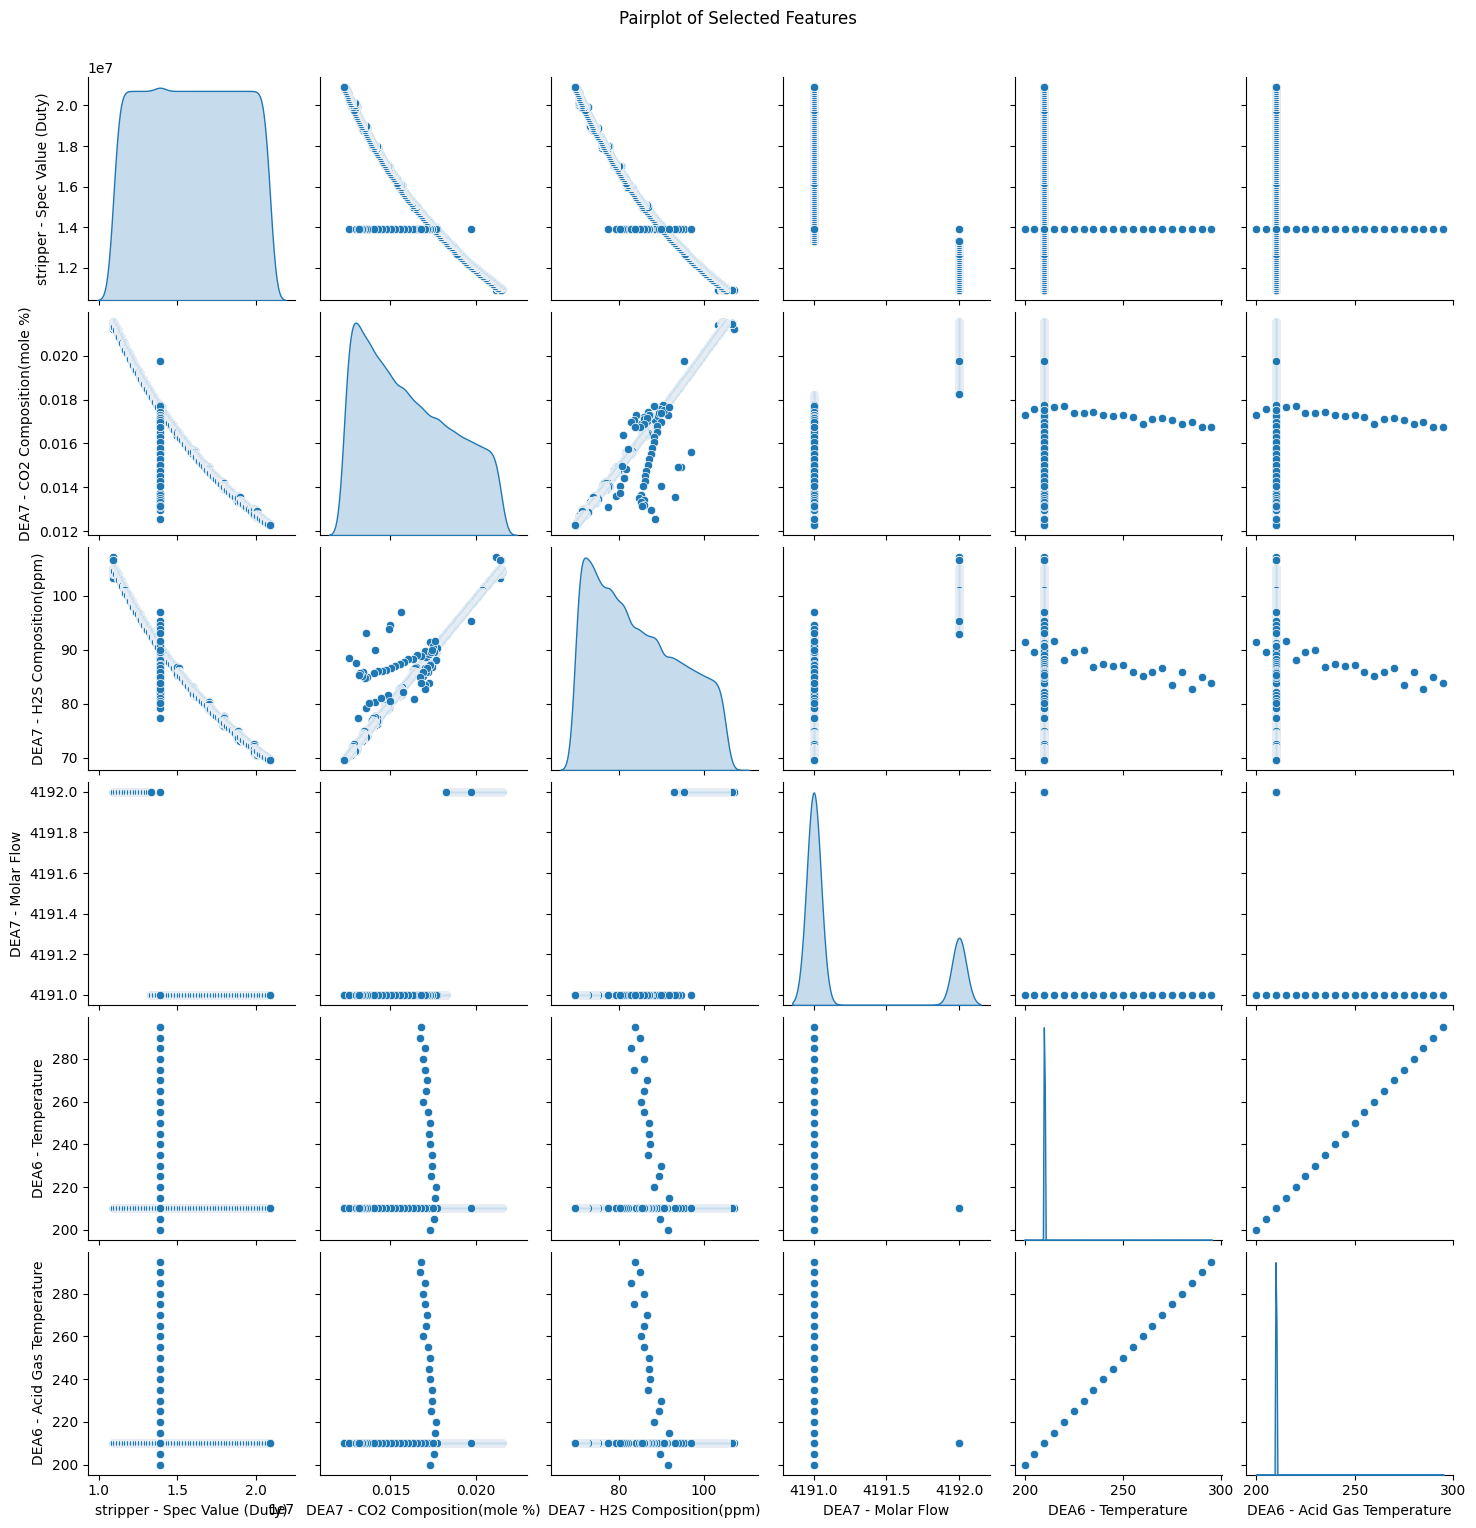

In [ ]:
# Pairplot of selected features

selected_cols = [
    'stripper - Spec Value (Duty)',
    'DEA7 - CO2 Composition(mole %)',
    'DEA7 - H2S Composition(ppm)',
    'DEA7 - Molar Flow',
    'DEA6 - Temperature',
    'DEA6 - Acid Gas Temperature'
]

sns.pairplot(df[selected_cols], diag_kind='kde')
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

The pairplot displays the relationships between selected process variables and the target variable (`stripper - Spec Value (Duty)`).

Key insights:

- Strong inverse trends are confirmed between:
  - `Reboiler Duty` and `DEA7 - CO2 Composition`
  - `Reboiler Duty` and `DEA7 - H2S Composition`
  These align with previous correlation results and support their importance for modeling.

- Some features like `DEA6 - Molar Flow` and `DEA7 - Molar Flow` are constant or nearly constant, appearing as vertical or horizontal lines. These offer little to no predictive value and can likely be dropped before modeling.

- `DEA6 - Acid Gas Temperature` and `DEA6 - Temperature` show distinct value bands, which may reflect discrete operating conditions or control settings in the simulation. These may still be useful but should be considered carefully.

- The diagonal plots show kernel density estimates (KDE) of each feature’s distribution. Features like `DEA7 - CO2` and `DEA7 - H2S` show strong bell-shaped distributions.

Overall, this plot supports feature selection by highlighting both redundant and highly informative variables.

##  Step 3: Data Preprocessing

In this step, we prepare the dataset for machine learning by:

- Dropping non-informative or constant features that are nearly constant or not useful for prediction
- Creating feature matrix `X` and target vector `y`
- Splitting the dataset into training and testing sets

This ensures the model is trained on meaningful patterns and can generalize to unseen data.

In [ ]:
# Drop non-informative columns

df_cleaned = df.drop(columns=[
    'DEA6 - Molar Flow',
    'DEA7 - Molar Flow',
])

In [ ]:
# Define target and features

target = 'stripper - Spec Value (Duty)'
X = df_cleaned.drop(columns=[target, 'State'])
y = df_cleaned[target]

In [ ]:
# Train-test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# Preview result

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (39932, 9)
Testing set size: (9983, 9)


A test size of `0.2` was selected to ensure that **20% of the dataset is set aside for testing**, while the remaining **80% is used for training** the machine learning model. This is a widely accepted split that provides a good balance.

The `random_state` was set to `42` to ensure that the split between training and testing sets is **reproducible**. Using a fixed random state means that every time the code is run, the dataset is split the same way.

## Step 4: Model Training —> Random Forest Regressor

We begin the modeling process with a **Random Forest Regressor**, an ensemble learning method that builds multiple decision trees and averages their outputs for better accuracy and robustness.

Reasons for choosing Random Forest:
- Handles non-linear relationships and complex feature interactions
- Performs well on tabular data without requiring feature scaling
- Automatically estimates feature importance

In [ ]:
# Initialize the model

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
# Train the model

rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

##  Step 5: Model Evaluation

After training the Random Forest Regressor, we evaluate its performance using:

- **R² Score**: Proportion of variance in the target explained by the model (1.0 = perfect)
- **Mean Squared Error (MSE)** and **Root Mean Squared Error (RMSE)**: Measures of average prediction error
- A scatter plot comparing predicted and actual values for visual assessment

In [ ]:
# Predict on the test set

y_pred = rf_model.predict(X_test)

In [ ]:
# Calculate metrics

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [ ]:
# Print results

print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

R² Score: 0.9997
MSE: 2620590040.96
RMSE: 51191.70


###  Model Evaluation Results (Random Forest Regressor)

- **R² Score:** `0.9997`  
  This means the model explains **99.97% of the variance** in the reboiler duty values. This is an **exceptionally strong fit**, indicating the model has captured the key patterns in the data.

- **MSE:** `2.62 × 10⁹`
- **RMSE:** `~51,192 Btu/hr`  
  On average, the model's predictions deviate from the actual values by about **51,192 Btu/hr**, which is relatively small considering the total range of reboiler duty values (10M–21M Btu/hr). This shows the model is making **highly accurate predictions**.

The combination of a **very high R²** and **low RMSE** confirms that the Random Forest Regressor is performing extremely well on this dataset.

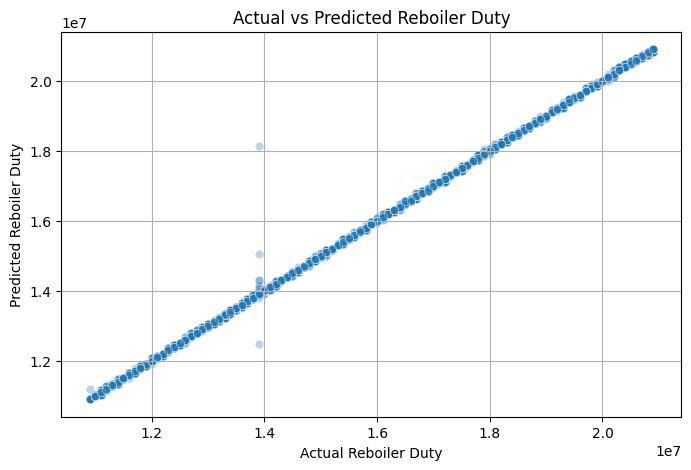

In [ ]:
# Scatter plot to visually compare actual vs predicted values

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.xlabel('Actual Reboiler Duty')
plt.ylabel('Predicted Reboiler Duty')
plt.title('Actual vs Predicted Reboiler Duty')
plt.grid(True)
plt.show()

The scatter plot above compares the actual reboiler duty values (x-axis) to the predicted values from the Random Forest model (y-axis).

Key observations:
- The points lie almost perfectly along the **diagonal line**, indicating a **strong match** between actual and predicted outputs.
- There is **minimal spread**, meaning the model has **low prediction error** and performs consistently across the full range of values.
- This confirms what was seen in the evaluation metrics: the model generalizes well and is highly accurate for this simulation-based dataset.

A nearly perfect alignment like this is a strong indicator of a well-trained model on clean, high-quality data.

##  Step 6: Feature Importance Analysis

Random Forest provides a built-in feature importance metric, showing how much each feature contributes to the model’s prediction accuracy.



In [ ]:
# Extract feature importances

importances = rf_model.feature_importances_
features = X.columns

In [ ]:
# Create dataFrame for easy sorting

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

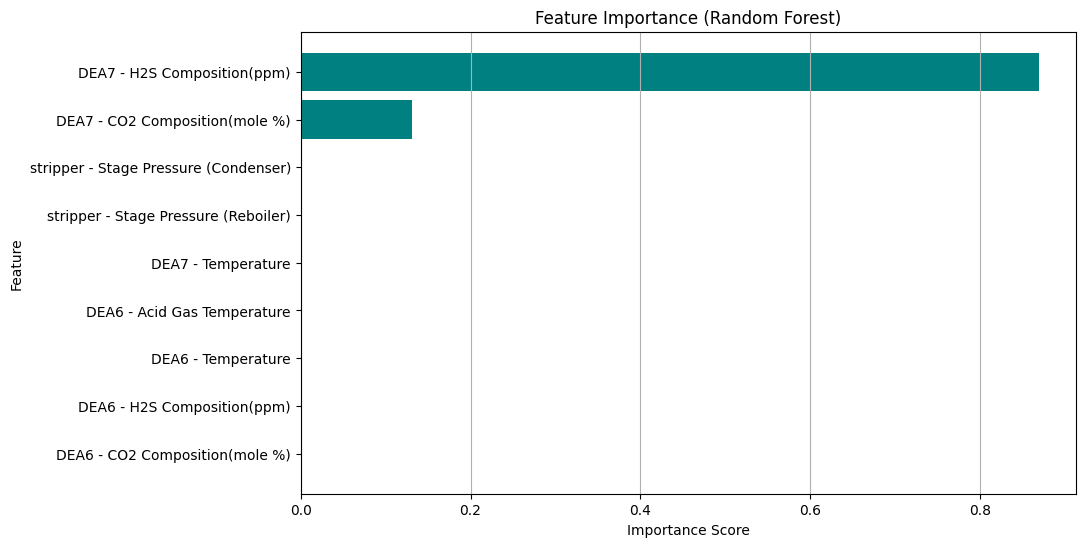

In [ ]:
# Plot feature importance

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x')
plt.show()

The bar chart above shows the importance of each input feature in predicting the **reboiler duty** based on the trained Random Forest model.

**Key observations:**
- **DEA7 - H₂S Composition (ppm)** is by far the most influential feature, contributing to over **80%** of the model’s predictive power. This suggests that the amount of H₂S in the lean amine is the strongest driver of reboiler energy consumption.
- **DEA7 - CO₂ Composition (mole %)** is the second most significant feature, though its influence is notably lower than H₂S.
- Other features like **stripper pressures** and **temperatures** have minimal importance, indicating they may have limited direct impact on predicting reboiler duty within this simulation dataset.

This aligns with domain knowledge: **better acid gas removal (lower CO₂ and H₂S downstream) requires more reboiler energy input**.



## Summary of workdone

In this analysis, we built a machine learning pipeline to predict the optimal reboiler duty using simulation data from the amine regeneration process.

### Key Findings:
- **Exploratory Data Analysis (EDA):** Revealed a clear inverse relationship between reboiler duty and lean amine acid gas composition (CO₂ and H₂S).
- **Random Forest Regressor** achieved **99.97% R² accuracy** with very low error (RMSE ~51,000 Btu/hr).
- **Feature Importance Analysis** showed:
   - **DEA7 - H₂S Composition (ppm)** is the most important factor influencing reboiler duty.
   - **DEA7 - CO₂ Composition (mole %)** is also significant.
- **Actual vs Predicted plots** confirmed strong agreement between predictions and simulation results.

This machine learning model provides a data-driven method to predict optimal reboiler duty based on key process variables. It can help:
- Optimize energy consumption in gas sweetening units
- Support real-time decision-making
- Reduce the need for repetitive simulations

In [ ]:
# importance_df = pd.DataFrame({
#     'Feature': X.columns,
#     'Importance': rf_model.feature_importances_
# })

# importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# importance_df.to_csv('feature_importance.csv', index=False)
# from google.colab import files
# files.download('feature_importance.csv')

In [ ]:
# df_cleaned = df.drop(columns=[
#     'DEA6 - Molar Flow',
#     'DEA7 - Molar Flow',
#     'State'
# ])
# df_cleaned.to_csv('amine_gen_data_cleaned.csv', index=False)
# from google.colab import files
# files.download('amine_gen_data_cleaned.csv')

In [ ]:
import pickle

with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)
from google.colab import files
files.download('rf_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# list(X.columns)